<a href="https://colab.research.google.com/github/lee777maker/Predictive-Insights-Hackathon/blob/main/PI_Hackathon_2025_Starter_Notebook_Job_Application_Success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Welcome to the Predictive Insights & Leap.ly Opportunity Application Challenge!
This starter notebook is designed to help you get up and running quickly by providing a brief introduction to the task and a template for working with the dataset. It also guides you through the correct workflow for preparing and submitting your predictions.

In this challenge, you'll use data from scholarship and job applications to predict to what extent candidates are likely to be succesful. The goal is not only to build accurate models but also to explore what factors might influence selection outcomes across diverse student profiles and application contexts.

NOTE: THIS NOTEBOOK USES THE FULL COMPETITION DATASET THAT WILL BE RELEASED VIA GOOGLE DRIVE AT THE IN-PERSON COMPETITION ON SATURDAY 16 AUGUST.

### Contents:
1. The Data
2. Univariate Analysis
3. Bivariate Analysis
4. Modeling
5. Submission

## 1. The Data

The dataset contains up to 100,000 anonymized student applications submitted for job and scholarship opportunities before 2023. Each row represents a single application, with candidates potentially appearing multiple times if they applied to more than one opportunity. This notebook will take you through the modelling and submission flow of a **sample** of 2000 rows from this data, and will not count towards the final submission or evaluation. The purpose of this notebook is to give you an opportunity to familiarize yourself with the data and start thinking about how you might approach the problem

Key fields include:
- ID: A unique identifier for each row
- Successful: Whether the candidate was ultimately successful (true/false).
- Progress: A numeric indicator of how far the candidate progressed in the application process. Not every opportunity will have 5 stages. The number of stages that an opportunity has can be detected using "Successful" candidates - whatever stage they reached will determine the number of stages for that opportunity
- Candidate/Opportunity: Anonymous unique IDs to track individuals and opportunities.
- Gender, Age, Race: Demographic information.
- Institution, Aggregate: The institution and academic performance (as a normalized percentage) of the candidate’s highest qualification.
- Qualification: The type of qualification (e.g., "Bachelor of Laws").
- Disciplines: A comma-separated list of subjects or specialisations - candidates may have multiple.
- Industry, Company: The sector and anonymized company offering the opportunity.

This dataset is well-suited for exploring patterns in selection, dealing with imbalanced outcomes, and applying multi-label feature handling techniques.
For this competition, the goal will be to predict what stage (1-5) the applicant makes it through the application process.
The initial data sample provided now includes just 2000 rows with data for one opportunity, and is an opportunity for anyone to experiment with the data format before we release the actual competition data

### 1.1. Initial Exploration

In [ ]:
import gdown

url = "https://drive.google.com/drive/folders/1nGxjvvQapRleVedHLzg57SEwvG4LwIm4?usp=sharing"
gdown.download_folder(url, quiet=False, use_cookies=False)


Retrieving folder contents


Processing file 1Ni7Gg1OC0RAOMDfcKMpbl58k2l0z1UMG test.csv
Processing file 1FNh8Xbd3w_zngltDaoVSgsJzM-zMSlgA train.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Ni7Gg1OC0RAOMDfcKMpbl58k2l0z1UMG
To: /content/PI Hackathon 2025/test.csv
100%|██████████| 4.16M/4.16M [00:00<00:00, 28.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FNh8Xbd3w_zngltDaoVSgsJzM-zMSlgA
To: /content/PI Hackathon 2025/train.csv
100%|██████████| 9.89M/9.89M [00:00<00:00, 51.7MB/s]
Download completed


['/content/PI Hackathon 2025/test.csv', '/content/PI Hackathon 2025/train.csv']

In [ ]:
# read in the data
import pandas as pd
data = pd.read_csv('/content/PI Hackathon 2025/train.csv')

In [ ]:
# read in the test data - this is the data we will submit predictions for
# we need to make whatever changes to this data that we made to the training data
test = pd.read_csv('/content/PI Hackathon 2025/test.csv')

The first step is to familiarize ourselves with the data we are looking at. This means looking at the variables, and what possible problems and tasks we might have to do to work with this.

In [ ]:
data.head()

,Industry,Company,Opportunity,Candidate,Gender,Age,Race,Institution,Aggregate,Qualification,Disciplines,Progress,Successful,NumCandidates
0,Banking (Commercial & Retail),Client C,3,4,Female,22,Black,University of Johannesburg,89,Bachelor of Science,"Computer Science, Information Technology",1,False,357
1,Legal,Client B,2,5,Female,27,Black,University of Johannesburg,68,Bachelor of Laws,Law,1,False,1443
2,Legal,Client B,2,6,Female,24,Black,University of Limpopo,70,Bachelor of Laws,Law,1,False,1443
3,Legal,Client B,2,10,Female,21,Black,University of the Western Cape,66,Bachelor of Laws,Law,1,False,1443
4,Banking (Commercial & Retail),Client C,4,11,Female,25,Black,North-West University,65,Bachelor of Commerce (Honours),"Economics, Risk Management",5,False,503


Looks like we are predicting the success of applicants for different opportunities given a variety of variables

Let's dive into the data. A few questions that come to mind:
1. How is the balance of the data? One assumes most scholarship / job applications receive many more applicants than positions
2. How many opportunities are there? Is there some relationship between the Industry, Opportunity ID and Discipline? How does this relationship affect the success of the application?
3. There are some missing values under the "Disciplines" column. What is the cause of that? Is it possible that these are only for the National Senior Certificate qualifications?
4. Seeing that we have both National Senior Certificate (high school) and university courses under "Qualification", how is the "Aggregate" column affected by this?

In [ ]:
data["Successful"].value_counts()

,count
Successful,
False,79746
True,786


Looks like the `Successful` variable is a highly imbalanced class. If we were to aim to apply binary classification with this variable as the target, we would have to think quite carefully about this.

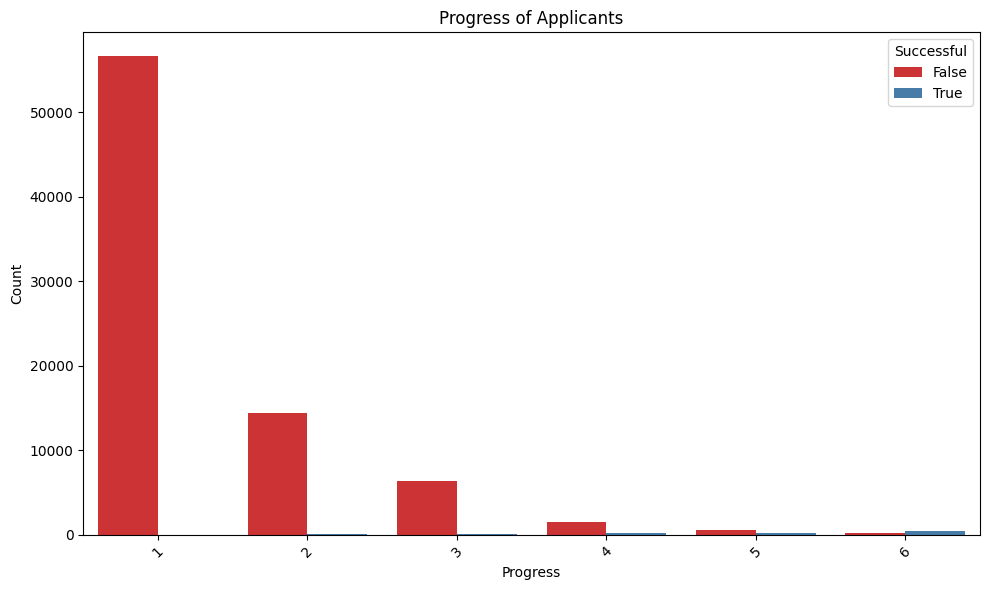

In [ ]:
# plot the progress of the applicants
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(x='Progress', hue='Successful', data=data, palette='Set1')
plt.title('Progress of Applicants')
plt.xlabel('Progress')
plt.ylabel('Count')
plt.legend(title='Successful', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This graph shows us how many applicants are rejected at each round of the opportunity.

#### 1.1.1. Categorical Data Formatting

In [ ]:
data["Disciplines"].value_counts()

,count
Disciplines,
Law,48121
Accounting and Auditing,4100
Economics,2038
Computer Science,1968
Finance,1846
...,...
"Languages and Linguistics, Mathematics, Biological Sciences, Chemistry, Physics, Information Systems",1
"Hospitality, Leisure, Recreation and Tourism, Psychology",1
"Economics, Accounting and Auditing, Biological Sciences, Languages and Linguistics, Mathematics",1


Looks like these disciplines are pretty standardized, but when a student has multiple disciplines/majors, they are comma separated in the row (for example "Computer Science, Mathematics" - for our model, we need to represent these such that they can be linked to the Disciplines "Computer Science" and "Mathematics" separately).

#### 1.1.2. Exploring NA's

In [ ]:
# view the number of nan values in each column
data.isna().sum()


,0
Industry,512
Company,0
Opportunity,0
Candidate,0
Gender,1045
Age,0
Race,1084
Institution,45
Aggregate,0
Qualification,46


We'll have to find a way to deal with the variables that have NA's

It may be interesting to explore the rows with missing `Disciplines`. Let's see if they are related to the `Qualification` being National Senior Certificate at all

In [ ]:
# filter show Qualifications that have NaN in the "Disciplines" column
data[data["Disciplines"].isna()]["Qualification"].value_counts()

,count
Qualification,
National Senior Certificate,216
Bachelor of Arts,22
Bachelor of Science,18
Postgraduate Diploma,12
Master of Commerce,7
Bachelor of Commerce,7
Certificate,6
Bachelor of Science (Honours),6
Master of Science,5


It seems like most of the NaN disciplines are National Senior Certificates, which take up about half of the applicants. "NaN" Disciplines can also be university qualifications however. It seems like some students did not specify, or took the general version of the course

#### 1.1.3. Exploring Categorical Values
Let's have a look at the value counts for some of the categorical variables

In [ ]:
data.nunique()

,0
Industry,10
Company,26
Opportunity,155
Candidate,29979
Gender,3
Age,64
Race,7
Institution,813
Aggregate,77
Qualification,238


In [ ]:
data["Institution"].value_counts()

,count
Institution,
University of South Africa,9832
University of the Witwatersrand,9556
University of Pretoria,8788
University of Johannesburg,7429
University of KwaZulu-Natal,5855
...,...
"Institut Superieur de Management Adonai, Republic of Benin",1
Don State Technical University,1
"Abdu Gusau Polytechnic, Talata Mafara Nigeria",1


In [ ]:
data["Qualification"].value_counts()

,count
Qualification,
Bachelor of Laws,41750
Bachelor of Commerce,6069
Bachelor of Science,5228
Bachelor of Commerce (Honours),4989
Bachelor of Science (Honours),3219
...,...
National Certificate,1
Bachelor of Project Planning and Management,1
Bachelor of Journalism,1


Looking at the categorical variables, there are many categories that have only have a few (one to ten) observations. For now we can deal with these by creating an "Other" category for each of these variable. This would be relevant to `Qualification` and `Institution`

### 1.2. Cleaning the Data

The dataset is mostly cleaned up already, but we need to deal with the problem of how "Disciplines" has been formatted. To make the multi-label Disciplines column usable for modeling, we apply multi-hot encoding to the top 15 most common disciplines (grouping the rest as "Other"), though alternatives like TF-IDF or embeddings could also be explored.

In [ ]:
import pandas as pd
from collections import Counter

# Ensure Disciplines is a list and clean entries
def to_disciplines_list(x):
    if isinstance(x, list):
        return [d.strip() for d in x if d.strip()]
    elif pd.isna(x) or x == '':
        return []
    else:
        return [d.strip() for d in str(x).split(',') if d.strip()]

data['Disciplines'] = data['Disciplines'].apply(to_disciplines_list)

# Flatten all disciplines into a single list
all_disciplines = [d for sublist in data['Disciplines'] for d in sublist]

# Get the top N most common disciplines
TOP_N = 15
top_disciplines = set([d for d, _ in Counter(all_disciplines).most_common(TOP_N)])

# Replace rare disciplines with 'Other'
def filter_disciplines(d_list):
    filtered = [d for d in d_list if d in top_disciplines]
    if not filtered:
        return ['Other']
    return filtered

data['Disciplines_filtered'] = data['Disciplines'].apply(filter_disciplines)

# One-hot encode the filtered disciplines (multi-hot)
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
discipline_dummies = pd.DataFrame(mlb.fit_transform(data['Disciplines_filtered']),
                                   columns=[f"Discipline_{d}" for d in mlb.classes_],
                                   index=data.index)

# Merge back into original dataframe and drop the old columns
data = data.drop(columns=['Disciplines', 'Disciplines_filtered'])
data = pd.concat([data, discipline_dummies], axis=1)

# Preview result
data.head()

,Industry,Company,Opportunity,Candidate,Gender,Age,Race,Institution,Aggregate,Qualification,...,Discipline_Finance,Discipline_Information Systems,Discipline_Information Technology,Discipline_Investments,Discipline_Law,Discipline_Marketing,Discipline_Mathematics,Discipline_Other,Discipline_Risk Management,Discipline_Statistics
0,Banking (Commercial & Retail),Client C,3,4,Female,22,Black,University of Johannesburg,89,Bachelor of Science,...,0,0,1,0,0,0,0,0,0,0
1,Legal,Client B,2,5,Female,27,Black,University of Johannesburg,68,Bachelor of Laws,...,0,0,0,0,1,0,0,0,0,0
2,Legal,Client B,2,6,Female,24,Black,University of Limpopo,70,Bachelor of Laws,...,0,0,0,0,1,0,0,0,0,0
3,Legal,Client B,2,10,Female,21,Black,University of the Western Cape,66,Bachelor of Laws,...,0,0,0,0,1,0,0,0,0,0
4,Banking (Commercial & Retail),Client C,4,11,Female,25,Black,North-West University,65,Bachelor of Commerce (Honours),...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# apply this to the test file
test['Disciplines'] = test['Disciplines'].apply(to_disciplines_list)
test['Disciplines_filtered'] = test['Disciplines'].apply(filter_disciplines)
discipline_dummies_test = pd.DataFrame(mlb.transform(test['Disciplines_filtered']),
                                       columns=[f"Discipline_{d}" for d in mlb.classes_],
                                       index=test.index)
test = test.drop(columns=['Disciplines', 'Disciplines_filtered'])
test = pd.concat([test, discipline_dummies_test], axis=1)
# Preview the modified test data
test.head()

,ID,Industry,Company,Opportunity,Candidate,Gender,Age,Race,Institution,Aggregate,...,Discipline_Finance,Discipline_Information Systems,Discipline_Information Technology,Discipline_Investments,Discipline_Law,Discipline_Marketing,Discipline_Mathematics,Discipline_Other,Discipline_Risk Management,Discipline_Statistics
0,0,Legal,Client A,1,1,Female,23,White,Stellenbosch University,70,...,0,0,0,0,1,0,0,0,0,0
1,1,Legal,Client B,2,2,Male,25,Black,University of the Western Cape,66,...,0,0,0,0,1,0,0,0,0,0
2,2,Legal,Client A,1,3,Male,23,Coloured,University of the Western Cape,67,...,0,0,0,0,1,0,0,0,0,0
3,3,Legal,Client B,2,7,Male,22,Black,University of Limpopo,70,...,0,0,0,0,1,0,0,0,0,0
4,4,Legal,Client B,2,8,Male,27,Black,Stellenbosch University,70,...,0,0,0,0,1,0,0,0,0,0


### 1.3. Other Adjustments
Based on what we've looked at, there are a few other adjustments to be made:
- Dealing with low-observation categories
- Dealing with NA's

#### 1.3.1. Dealing with low-observation categories
Considering the low-observation categories we identified earlier (for `Institution` and `Qualification`), for now we will deal with these by creating an `"Other"` category for these

In [ ]:
import pandas as pd

# set Institutions with less than 15 observations to "Other" (applied to both train and test)
institution_counts = data['Institution'].value_counts()
rare_Institution = institution_counts[institution_counts <= 15].index

data['Institution'] = data['Institution'].replace(rare_Institution, 'Other')
test['Institution'] = test['Institution'].replace(rare_Institution, 'Other')

# set Qualifications with less than 6 observations to "Other" (applied to both train and test)
qualification_counts = data['Qualification'].value_counts()
rare_Qualification = qualification_counts[qualification_counts <= 6].index

data['Qualification'] = data['Qualification'].replace(rare_Qualification, 'Other')
test['Qualification'] = test['Qualification'].replace(rare_Qualification, 'Other')

#### 1.2.2. Dealing with NA's
We'll deal with the categorical variables that have NA's as follows:
- `Industry` : impute
- `Gender` : set to "Other"
- `Race` : set to "Other"
- `Institution` : impute
- `Qualification` : impute

In [ ]:
# Industry: impute (using mode from train)
# Compute mode Industry per Qualification from the training set
# Compute mode per qualification from train
industry_mode_by_qual = (
    data.groupby('Qualification')['Industry']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
)

# Global fallback
global_industry_mode = data['Industry'].mode()[0]

# Fill NAs in train
data['Industry'] = data.apply(
    lambda row: industry_mode_by_qual.get(row['Qualification'], global_industry_mode)
    if pd.isna(row['Industry']) else row['Industry'],
    axis=1
)

# Fill NAs in test
test['Industry'] = test.apply(
    lambda row: industry_mode_by_qual.get(row['Qualification'], global_industry_mode)
    if pd.isna(row['Industry']) else row['Industry'],
    axis=1
)

global_industry_mode = data['Industry'].mode()[0]
test['Industry'] = test['Industry'].fillna(global_industry_mode)

##############################################
# Gender: set NA to "Other"
data['Gender'] = data['Gender'].fillna('Other')
test['Gender'] = test['Gender'].fillna('Other')

###############################################
# Race: set NA to "Other"
data['Race'] = data['Race'].fillna('Other')
test['Race'] = test['Race'].fillna('Other')

###############################################
# Institution: impute (using mode from train)
institution_mode = data['Institution'].mode()[0]
data['Institution'] = data['Institution'].fillna(institution_mode)

# Get valid categories from train
valid_institutions = set(data['Institution'].unique())

# Fill NAs in test, then replace unseen with 'Other'
test['Institution'] = (
    test['Institution']
    .fillna(institution_mode)
    .apply(lambda x: x if x in valid_institutions else 'Other')
)

###############################################
# Qualification: impute (using mode from train)
Qualification_mode = data['Qualification'].mode()[0]
data['Qualification'] = data['Qualification'].fillna(Qualification_mode)

# Get valid categories from train
valid_Qualifications = set(data['Qualification'].unique())

# Fill NAs in test, then replace unseen with 'Other'
test['Qualification'] = (
    test['Qualification']
    .fillna(Qualification_mode)
    .apply(lambda x: x if x in valid_Qualifications else 'Other')
)


## 2. Univariate Analysis

This univariate analysis helps explore which individual features correlate with the target outcome. Try extending this to interaction terms or more nuanced slices of the data — and keep an eye out for imbalanced classes or surprising patterns!

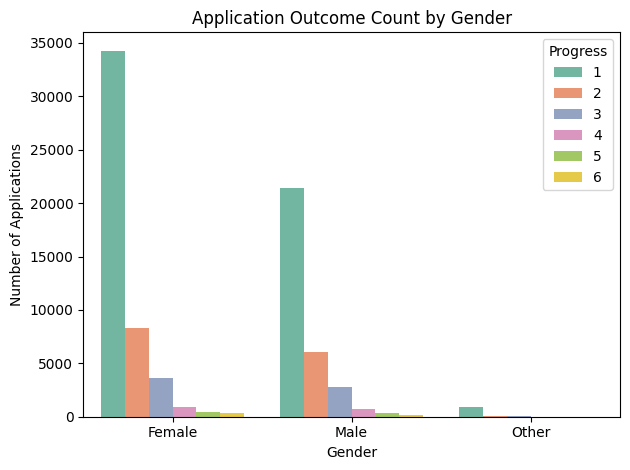

In [ ]:
# Countplot of success count by gender
sns.countplot(data=data, x='Gender', hue='Progress', palette='Set2')
plt.title('Application Outcome Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Applications')
plt.tight_layout()
plt.show()

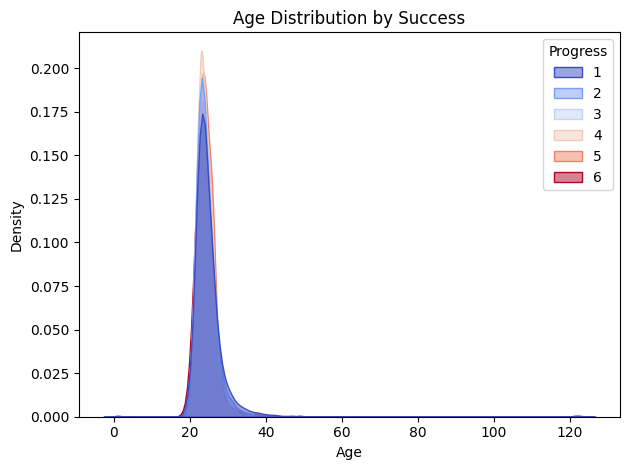

In [ ]:
# Age distribution split by Target
sns.kdeplot(data=data, x='Age', hue='Progress', fill=True, common_norm=False, palette='coolwarm', alpha=0.5)
plt.title('Age Distribution by Success')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


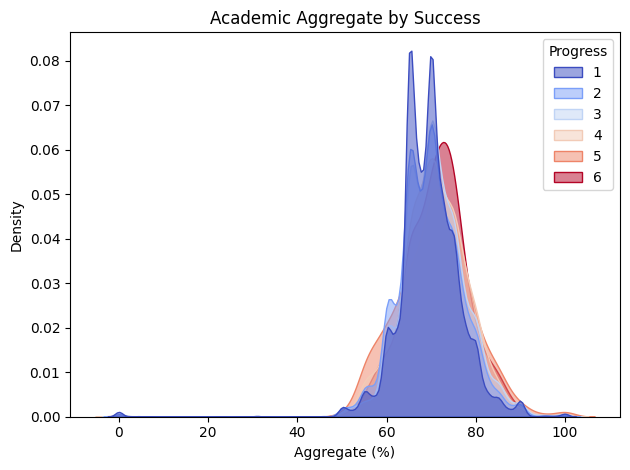

In [ ]:
# Aggregate score (academic performance) vs success
sns.kdeplot(data=data, x='Aggregate', hue='Progress', fill=True, common_norm=False, palette='coolwarm', alpha=0.5)
plt.title('Academic Aggregate by Success')
plt.xlabel('Aggregate (%)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


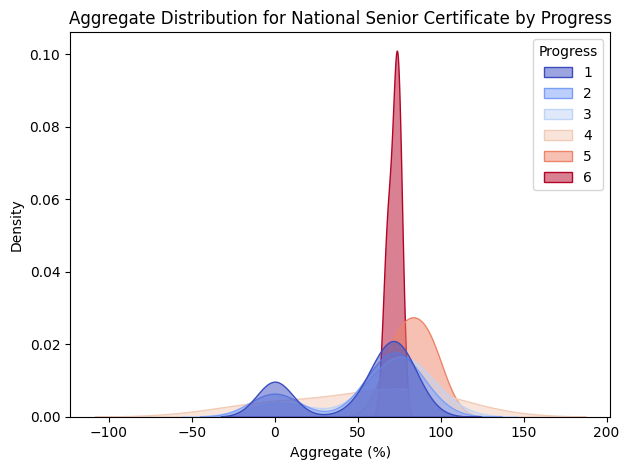

In [ ]:
# plot the success rate by aggregate but filter the one to include only those with Qualification being National Senior Certificate
sns.kdeplot(data=data[data['Qualification'] == 'National Senior Certificate'], x='Aggregate', hue='Progress', fill=True, common_norm=False, palette='coolwarm', alpha=0.5)
plt.title('Aggregate Distribution for National Senior Certificate by Progress')
plt.xlabel('Aggregate (%)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


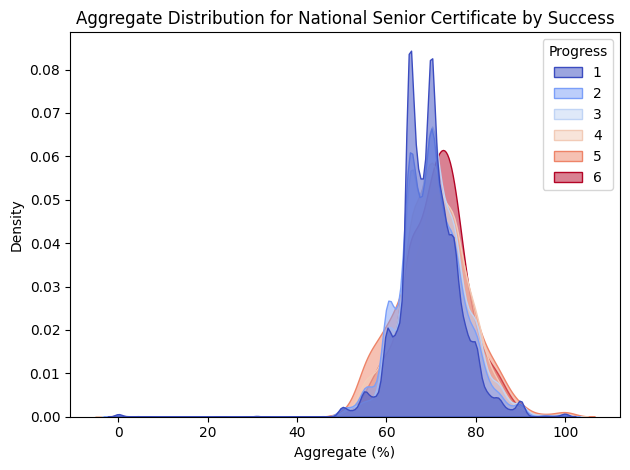

In [ ]:
# plot the success rate by aggregate but filter to include only those with Qualification not being National Senior Certificate
sns.kdeplot(data=data[data['Qualification'] != 'National Senior Certificate'], x='Aggregate', hue='Progress', fill=True, common_norm=False, palette='coolwarm', alpha=0.5)
plt.title('Aggregate Distribution for National Senior Certificate by Success')
plt.xlabel('Aggregate (%)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


/tmp/ipython-input-867543501.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data[data['Qualification'].isin(top_quals)], x='Qualification', y='Progress', palette='viridis')


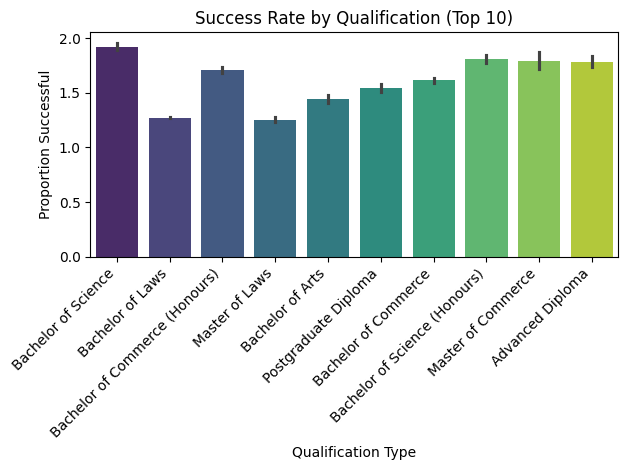

In [ ]:
# Qualification (bachelor, diploma, etc.) vs success
top_quals = data['Qualification'].value_counts().nlargest(10).index
sns.barplot(data=data[data['Qualification'].isin(top_quals)], x='Qualification', y='Progress', palette='viridis')
plt.title('Success Rate by Qualification (Top 10)')
plt.ylabel('Proportion Successful')
plt.xlabel('Qualification Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


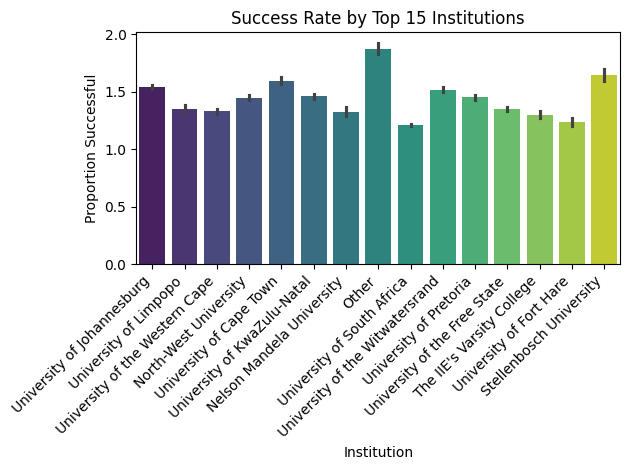

In [ ]:
# plot how Institution affects Target

# Get top 10 most common institutions
top_institutions = data['Institution'].value_counts().head(15).index

# Filter the dataset
data_top = data[data['Institution'].isin(top_institutions)]

# Plot
sns.barplot(
    data=data_top,
    x='Institution',
    y='Progress',
    palette='viridis',
    hue='Institution'
)
plt.title('Success Rate by Top 15 Institutions')
plt.ylabel('Proportion Successful')
plt.xlabel('Institution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 3. Multivariate Analysis

/tmp/ipython-input-2945478867.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Aggregate_bin', y='Progress', estimator='mean', palette='coolwarm')


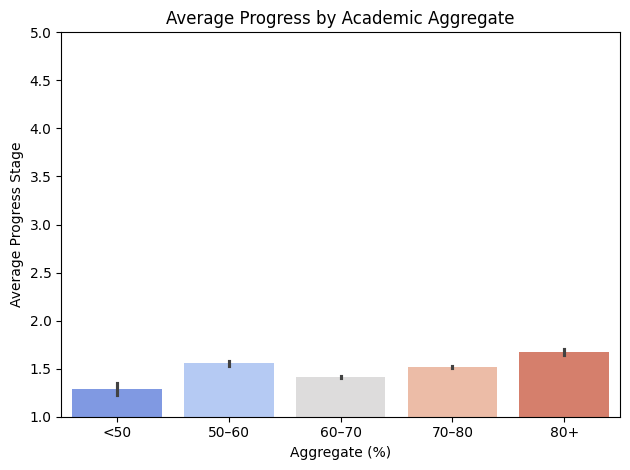

In [ ]:
# Bin academic scores for readability
data['Aggregate_bin'] = pd.cut(
    data['Aggregate'],
    bins=[0, 50, 60, 70, 80, 100],
    labels=['<50', '50–60', '60–70', '70–80', '80+']
)

# Plot average progress by aggregate bin
sns.barplot(data=data, x='Aggregate_bin', y='Progress', estimator='mean', palette='coolwarm')
plt.title('Average Progress by Academic Aggregate')
plt.xlabel('Aggregate (%)')
plt.ylabel('Average Progress Stage')
plt.ylim(1, 5)
plt.tight_layout()
plt.show()

# remove the 'Aggregate_bin' column
data = data.drop(columns=['Aggregate_bin'])


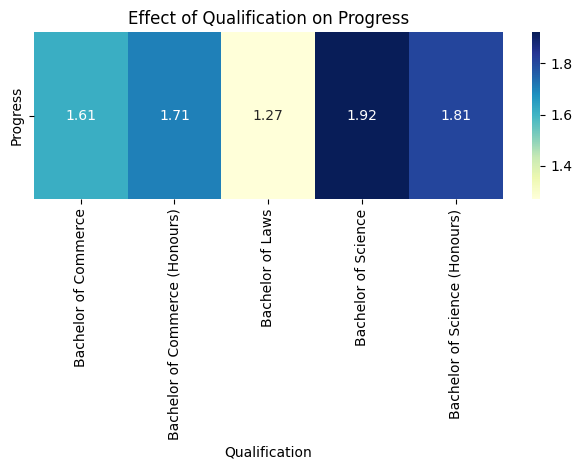

In [ ]:
top_quals = data['Qualification'].value_counts().nlargest(5).index
qual_disciplines = data[data['Qualification'].isin(top_quals)].groupby('Qualification')[[
    col for col in data.columns if col.startswith('Progress')
]].mean().T

# Heatmap of proportion of success for top 5 qualifications and disciplines
sns.heatmap(qual_disciplines, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Effect of Qualification on Progress')
plt.xlabel('Qualification')
plt.tight_layout()
plt.show()


## 4. Modelling

Below we will run a very brief regression model on this data, to complete the flow of the challenge

Training set size: 64425
Validation set size: 16107

MODEL PERFORMANCE
Training   - MSE: 0.0404, MAE: 0.1366, R²: 0.1032
Validation - MSE: 0.0408, MAE: 0.1373, R²: 0.0937

Intercept: 0.0094

Top 10 Most Important Features:
                                         Feature  Coefficient
                            Discipline_Marketing     0.130485
                                  Discipline_Law    -0.085256
Discipline_Electrical and Electronic Engineering     0.078114
               Discipline_Information Technology     0.032489
                     Discipline_Computer Science     0.030978
                                Discipline_Other     0.026296
                          Discipline_Investments    -0.019836
                                  Gender_encoded    -0.016577
                  Discipline_Information Systems     0.014504
              Discipline_Accounting and Auditing     0.013926


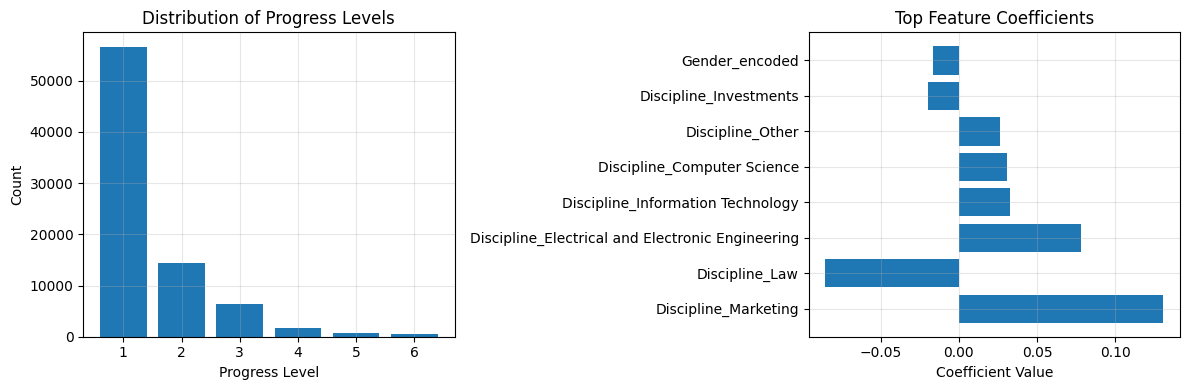


Model ready! Use predict_progress() to make predictions on new data.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Copy data
df = data.copy()

# Compute max_progress per Opportunity
max_progress_per_opportunity = df.groupby('Opportunity')['Progress'].max()
df['max_progress'] = df['Opportunity'].map(max_progress_per_opportunity)

# Normalize Progress to 0-1
# Compute normalized progress safely
df['Progress_normalized'] = (df['Progress'] - 1) / (df['max_progress'] - 1)
df['Progress_normalized'] = df['Progress_normalized'].fillna(0)  # handle max_progress = 1

# Encode categorical variables
categorical_cols = ['Industry', 'Company', 'Gender', 'Race', 'Institution', 'Qualification']
label_encoders = {}

for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le

# Select features
feature_columns = ['Age', 'Aggregate', 'NumCandidates'] + [col + '_encoded' for col in categorical_cols if col in df.columns]
discipline_cols = [col for col in df.columns if col.startswith('Discipline_')]
feature_columns.extend(discipline_cols)

# Prepare X and y
X = df[feature_columns]
y = df['Progress_normalized']

# Split into train and validation sets (stratify by rounded normalized progress for balance)
# Stratify by rounded normalized progress
y_strat = np.round(df['Progress_normalized'] * 10)
X_train, X_validation, y_train, y_validation = train_test_split(
    X, df['Progress_normalized'], test_size=0.2, random_state=42, stratify=y_strat
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_validation.shape[0]}")

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict normalized progress
y_train_pred = np.clip(model.predict(X_train), 0, 1)
y_val_pred = np.clip(model.predict(X_validation), 0, 1)

# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_validation, y_val_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_validation, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_validation, y_val_pred)

print("\n" + "="*40)
print("MODEL PERFORMANCE")
print("="*40)
print(f"Training   - MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Validation - MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nIntercept: {model.intercept_:.4f}")
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
progress_counts = df['Progress'].value_counts().sort_index()
ax1.bar(progress_counts.index, progress_counts.values)
ax1.set_xlabel('Progress Level')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Progress Levels')
ax1.grid(True, alpha=0.3)

top_features = feature_importance.head(8)
ax2.barh(range(len(top_features)), top_features['Coefficient'])
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features['Feature'])
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Top Feature Coefficients')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prediction function
def predict_progress(new_data):
    """Predict progress for new data, scaled by opportunity max_progress"""
    new_df = new_data.copy()

    # Encode categorical variables
    for col in categorical_cols:
        if col in new_df.columns and col in label_encoders:
            new_df[col + '_encoded'] = label_encoders[col].transform(new_df[col])

    # Ensure max_progress column exists
    if 'max_progress' not in new_df.columns:
        new_df['max_progress'] = new_df['Opportunity'].map(max_progress_per_opportunity)

    # Select features and predict normalized progress
    X_new = new_df[feature_columns]
    y_pred_normalized = np.clip(model.predict(X_new), 0, 1)

    # Scale back to actual progress
    y_pred_actual = 1 + y_pred_normalized * (new_df['max_progress'] - 1)
    return y_pred_actual

print(f"\nModel ready! Use predict_progress() to make predictions on new data.")


Interestingly, whether someone studied Information Systems is a major influence on the model - this might suggest something about what skills are in demand in South Africa - or more specifically by the particular opportunity this sample data is made from

## 5. Submission

We'll set up a simple submission file for the data we've been working with. It is important to note that what we have up so far is just a sample of the final data we will be evaluating and running the hackathon with. You can upload your predictions and get real results for the sample, but nothing will count until we upload the final training and test sets on the **16 August 2025**

In [ ]:
# Make predictions on test
test_predictions = predict_progress(test)

In [ ]:
# Create submission DataFrame with ID and predictions
submission = pd.DataFrame({
    'ID': test['ID'],
    'Progress': test_predictions
})

print(f"\nPredictions on test:")
print(submission.head())
print(f"\nTotal predictions: {len(submission)}")


Predictions on test:
   ID  Progress
0   0  1.332290
1   1  1.000000
2   2  1.141084
3   3  1.000000
4   4  1.000000

Total predictions: 34512


Save your submission to a csv file

In [ ]:
submission.to_csv('/content/PI Hackathon 2025/submission.csv', index=False)

Et voilà! You are now ready to submit.

Predictive Insights is a leader in behavioural science and artificial intelligence to improve business efficiency and profitability. Through a combination of data science, machine learning and behavioural insights, we help customers to accurately predict sales, staffing and stock levels. Our solution improves sales forecasting on average by 50 percent. We operate in Africa as well as Europe, Middle East and India in the restaurant, food processing, retail and financial service sectors. We are part of Alphawave, a specialised technology investment group supporting businesses seeking to do things that are complex to replicate.